<a href="https://colab.research.google.com/github/sagnikCodes/Design-Credits/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import math 
import matplotlib.pyplot as plt 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras.optimizers import Adam
import keras_tuner as kt
import yfinance as yf
import datetime
import time
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU,LSTM

In [ ]:
company_name = input('Enter company name: ')
current_timestamp = int(time.time())
years_back=20
ten_years_ago = datetime.datetime.now() - datetime.timedelta(days=365*years_back)
start_timestamp = int(ten_years_ago.timestamp())
url = f'https://query1.finance.yahoo.com/v7/finance/download/{company_name}.NS?period1={start_timestamp}&period2={current_timestamp}&interval=1d&events=history&includeAdjustedClose=true'

Enter company name: ADANIPORTS


In [ ]:
#So, we extract Closing Price of Stock Price
data=pd.read_csv(url)['Close']

In [ ]:
if(data.isnull().sum()!=0):
  data.interpolate(method='linear', inplace=True)

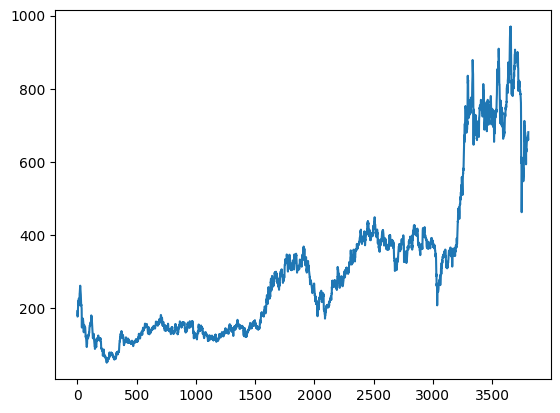

In [ ]:
plt.plot(data)

In [ ]:
train,test,validation=data[0:int(0.7*len(data))],data[int(0.7*len(data)):int(0.9*len(data))],data[int(0.9*len(data)):len(data)]

In [ ]:
training_data=np.array([train]).T
validation_data=np.array([validation]).T
testing_data=np.array([test]).T

In [ ]:
scaler=StandardScaler()
training_data=scaler.fit_transform(training_data)
validation_data=scaler.fit_transform(validation_data)
testing_data=scaler.fit_transform(testing_data)

In [ ]:
def create_data(data,time_step=1): 
    x = [] 
    y = []
    for i in range(len(data)-time_step-1):
        x.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0]) 
    x = np.array(x) 
    y = np.array(y)
    return x,y

In [ ]:
time_step=100
X_train,Y_train = create_data(training_data,time_step)  
X_test,Y_test = create_data(testing_data,time_step)  
X_valid, Y_valid = create_data(validation_data,time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1] , 1)

In [ ]:
X_train.shape

(2563, 100, 1)

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers',1,10)):
        if i == 0:
            model.add(LSTM(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                   return_sequences=True))
        model.add(Dropout(hp.Float('dropout_' + str(i), 0, 0.5, step=0.1)))
    model.add(GRU(units=hp.Int('units_last', min_value=32, max_value=512, step=32)))
    model.add(Dropout(hp.Float('dropout_last', 0, 0.5, step=0.1)))
    model.add(Dense(units=1,activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='Stock_Market_LSTM',
    project_name='my_project'
)
early_stopping=keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
tuner.search(x=X_train,y=Y_train,
             epochs=5,
             validation_data=(X_valid,Y_valid),
             callbacks=[early_stopping]
        )

Trial 5 Complete [00h 00m 13s]
val_loss: 0.18201182782649994

Best val_loss So Far: 0.18201182782649994
Total elapsed time: 00h 02m 04s


In [ ]:
best_hp=tuner.get_best_hyperparameters()[0]
model=build_model(best_hp)

In [ ]:
model.fit(X_train,Y_train,epochs=100,initial_epoch=5 ,validation_data=(X_valid,Y_valid),callbacks=early_stopping)

Epoch 6/100
81/81 [==============================] - 7s 28ms/step - loss: 0.0569 - mae: 0.1557 - val_loss: 0.3174 - val_mae: 0.3869
Epoch 7/100
81/81 [==============================] - 1s 14ms/step - loss: 0.0211 - mae: 0.1120 - val_loss: 0.3076 - val_mae: 0.3804
Epoch 8/100
81/81 [==============================] - 1s 13ms/step - loss: 0.0199 - mae: 0.1064 - val_loss: 0.2329 - val_mae: 0.3205
Epoch 9/100
81/81 [==============================] - 1s 13ms/step - loss: 0.0181 - mae: 0.1009 - val_loss: 0.2111 - val_mae: 0.3108
Epoch 10/100
81/81 [==============================] - 1s 14ms/step - loss: 0.0167 - mae: 0.0970 - val_loss: 0.1833 - val_mae: 0.2889
Epoch 11/100
81/81 [==============================] - 1s 17ms/step - loss: 0.0156 - mae: 0.0943 - val_loss: 0.1685 - val_mae: 0.2818
Epoch 12/100
81/81 [==============================] - 1s 18ms/step - loss: 0.0151 - mae: 0.0926 - val_loss: 0.1788 - val_mae: 0.2882
Epoch 13/100
81/81 [==============================] - 1s 13ms/step - loss

In [ ]:
train_predict=model.predict(X_train)
valid_predict=model.predict(X_valid)

9/9 [==============================] - 0s 5ms/step


In [ ]:
train_predict=scaler.inverse_transform(train_predict)
valid_predict=scaler.inverse_transform(valid_predict)

In [ ]:
train_predict.shape

(2563, 1)

In [ ]:
Y_train = Y_train.reshape(len(Y_train),1)

In [ ]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))

472.2935529600941

In [ ]:
math.sqrt(mean_squared_error(Y_valid,valid_predict))

490.01770331539683

[[-0.72914785]
 [-0.63508852]
 [-0.58635411]
 ...
 [ 1.68450927]
 [ 1.73916012]
 [ 1.79531476]]


Text(0.5, 1.0, 'Training dataset prediction')

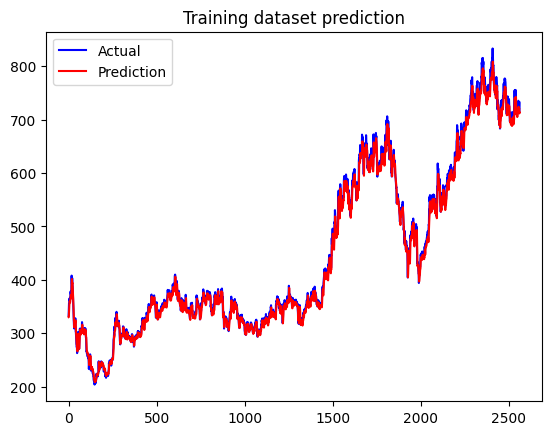

In [ ]:
print(Y_train) 
Y_train = scaler.inverse_transform(Y_train)
plt.plot(Y_train,color = "blue" , label = 'Actual') 
plt.plot(train_predict,color = "red" , label = 'Prediction') 
plt.legend() 
plt.title("Training dataset prediction")

Text(0.5, 1.0, 'Validatoin dataset ')

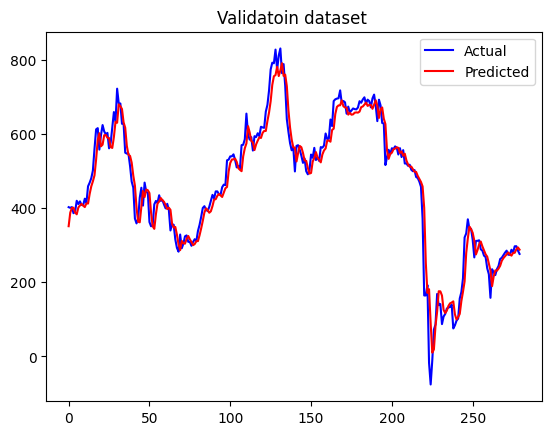

In [ ]:
Y_valid = Y_valid.reshape(len(Y_valid),1)
Y_valid = scaler.inverse_transform(Y_valid)
plt.plot(Y_valid,color = "blue" , label = 'Actual')  
plt.plot(valid_predict,color = "red" , label = 'Predicted') 
plt.legend() 
plt.title("Validatoin dataset ")

In [ ]:
test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)

21/21 [==============================] - 0s 6ms/step


In [ ]:
validation_predict=scaler.inverse_transform(model.predict(X_valid))

9/9 [==============================] - 0s 10ms/step


In [ ]:
Y_test = Y_test.reshape(len(Y_test),1) 
Y_test=scaler.inverse_transform(Y_test)

Text(0.5, 1.0, 'Testing data')

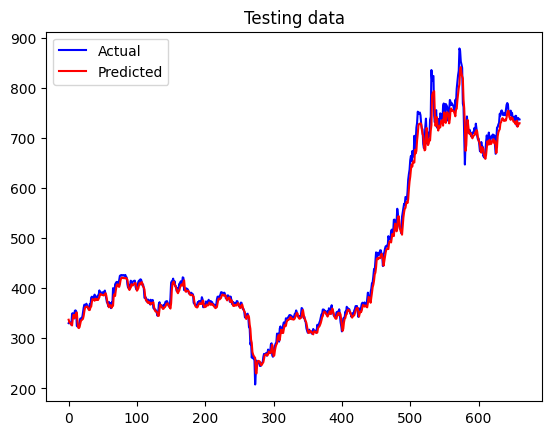

In [ ]:
plt.plot(Y_test,color = "blue" , label =  'Actual')  
plt.plot(test_predict,color = "red" , label = 'Predicted') 
plt.legend() 
plt.title("Testing data")